In [1]:
import os
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

In [2]:
conn = psycopg2.connect(
    host=os.getenv('GAUSSDB_HOST', 'localhost'),
    port=os.getenv('GAUSSDB_PORT', '5432'),
    dbname=os.getenv('GAUSSDB_DB_SILVER', 'silver'),
    user=os.getenv('GAUSSDB_USER', 'postgres'),
    password=os.getenv('GAUSSDB_PASSWORD', 'postgres')
)


In [3]:
df_real = pd.read_sql("SELECT * FROM battery_state_real ORDER BY timestamp", conn)
df_pred = pd.read_sql("SELECT * FROM battery_state_predicted ORDER BY timestamp", conn)

conn.close()

df_real['timestamp'] = pd.to_datetime(df_real['timestamp'])
df_pred['timestamp'] = pd.to_datetime(df_pred['timestamp'])

C:\Users\hamza\AppData\Local\Temp\ipykernel_8796\3678180538.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_real = pd.read_sql("SELECT * FROM battery_state_real ORDER BY timestamp", conn)
C:\Users\hamza\AppData\Local\Temp\ipykernel_8796\3678180538.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pred = pd.read_sql("SELECT * FROM battery_state_predicted ORDER BY timestamp", conn)


In [4]:
print("REAL:", df_real.timestamp.min(), "→", df_real.timestamp.max(), "rows:", len(df_real))
print("PRED:", df_pred.timestamp.min(), "→", df_pred.timestamp.max(), "rows:", len(df_pred))

df_real.head()


REAL: 2024-01-01 00:00:00 → 2025-11-12 23:00:00 rows: 50
PRED: 2025-11-14 00:00:00 → 2025-11-20 23:00:00 rows: 336


,id,timestamp,battery_type,battery_capacity_kwh,solar_production_kwh,consumption_kwh,net_energy_kwh,soc_start_pct,soc_end_pct,energy_stored_kwh,battery_charge_kwh,battery_discharge_kwh,grid_import_kwh,grid_export_kwh,created_at
0,2024010100_main,2024-01-01 00:00:00,main,3000.0,0.0,0.0000,0.0000,100.00,100.00,3000.00,0.0,0.0000,0.0,0.0,2025-11-13 03:54:16.267684
1,2024010100_backup,2024-01-01 00:00:00,backup,1000.0,0.0,0.0000,0.0000,100.00,100.00,1000.00,0.0,0.0000,0.0,0.0,2025-11-13 03:54:16.267684
2,2025111200_main,2025-11-12 00:00:00,main,3000.0,0.0,78.5385,-78.5385,100.00,97.38,2921.46,0.0,78.5385,0.0,0.0,2025-11-13 04:03:12.578960
3,2025111200_backup,2025-11-12 00:00:00,backup,1000.0,0.0,78.5385,-78.5385,100.00,92.15,921.46,0.0,78.5385,0.0,0.0,2025-11-13 04:03:12.578960
4,2025111201_main,2025-11-12 01:00:00,main,3000.0,0.0,79.0484,-79.0484,97.38,94.75,2842.41,0.0,79.0484,0.0,0.0,2025-11-13 04:03:12.578960


c:\Users\hamza\miniconda3\envs\cenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128267 (\N{BATTERY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


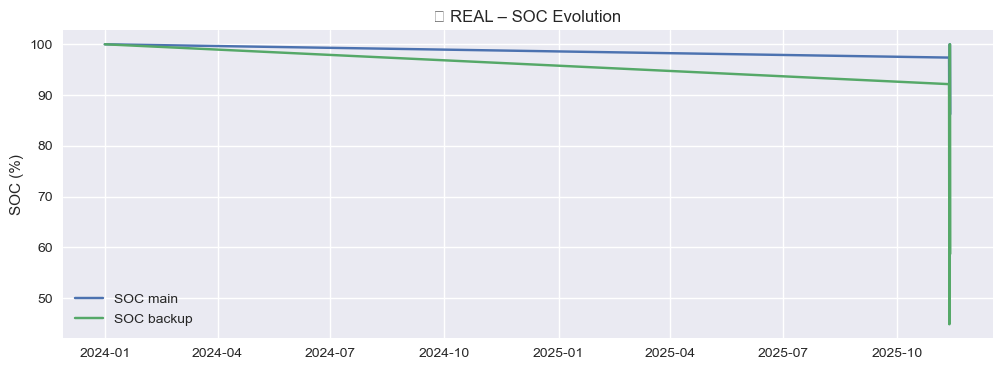

c:\Users\hamza\miniconda3\envs\cenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


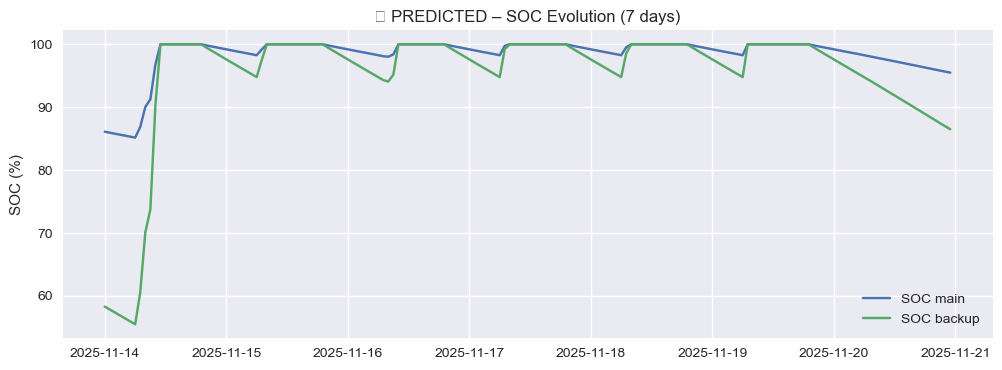

In [5]:
def plot_soc(df, title):
    plt.figure(figsize=(12,4))
    for btype in ['main', 'backup']:
        tmp = df[df.battery_type==btype]
        plt.plot(tmp['timestamp'], tmp['soc_end_pct'], label=f"SOC {btype}")
    plt.ylabel("SOC (%)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_soc(df_real, "🔋 REAL – SOC Evolution")
plot_soc(df_pred, "🔮 PREDICTED – SOC Evolution (7 days)")


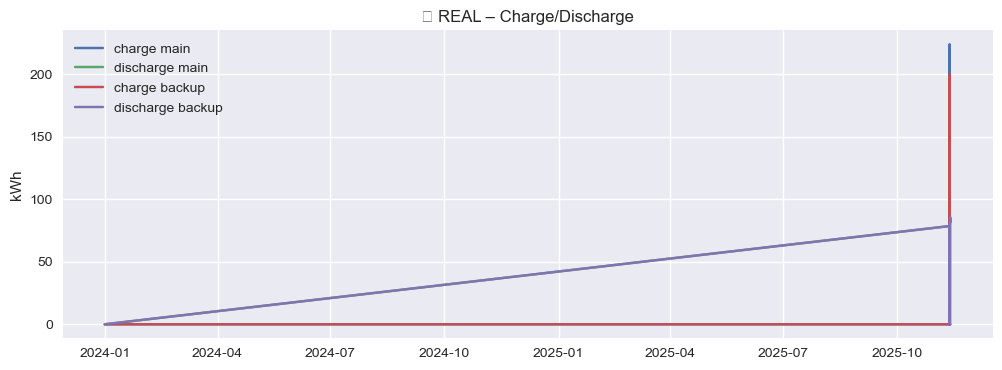

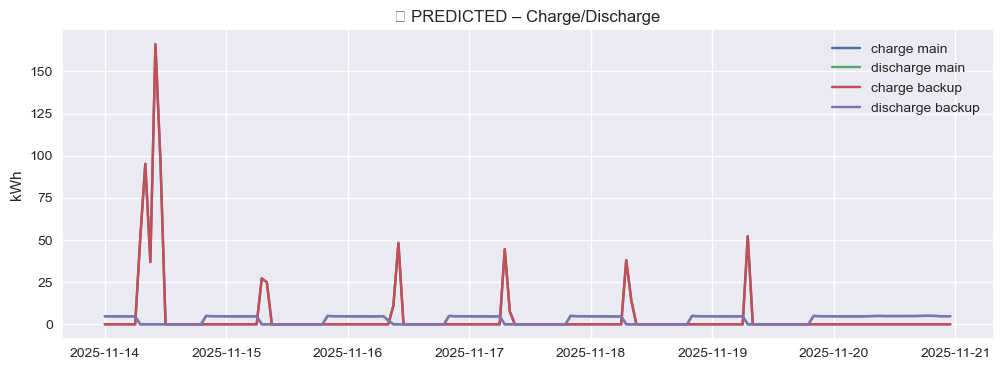

In [6]:
def plot_charge_discharge(df, title):
    plt.figure(figsize=(12,4))
    for btype in ['main','backup']:
        tmp = df[df.battery_type==btype]
        plt.plot(tmp['timestamp'], tmp['battery_charge_kwh'], label=f"charge {btype}")
        plt.plot(tmp['timestamp'], tmp['battery_discharge_kwh'], label=f"discharge {btype}")
    plt.ylabel("kWh")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_charge_discharge(df_real, "🔋 REAL – Charge/Discharge")
plot_charge_discharge(df_pred, "🔮 PREDICTED – Charge/Discharge")


c:\Users\hamza\miniconda3\envs\cenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


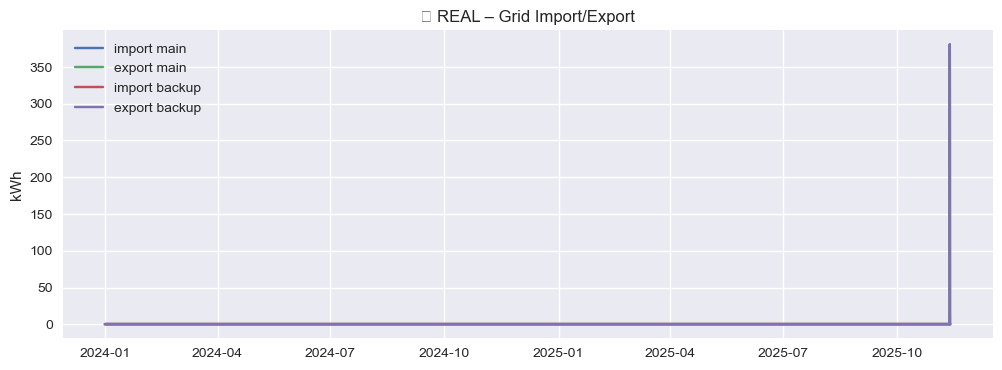

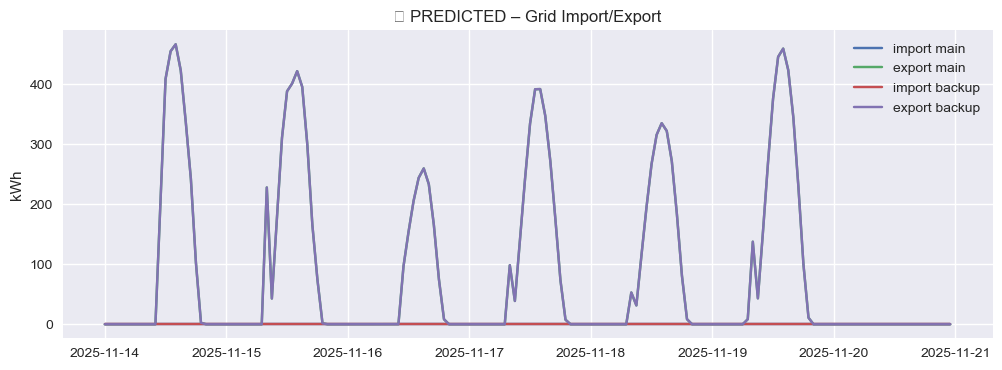

In [7]:
def plot_grid(df, title):
    plt.figure(figsize=(12,4))
    for btype in ['main','backup']:
        tmp = df[df.battery_type == btype]
        plt.plot(tmp['timestamp'], tmp['grid_import_kwh'], label=f"import {btype}")
        plt.plot(tmp['timestamp'], tmp['grid_export_kwh'], label=f"export {btype}")
    plt.ylabel("kWh")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_grid(df_real, "🔌 REAL – Grid Import/Export")
plot_grid(df_pred, "🔮 PREDICTED – Grid Import/Export")


In [8]:
def battery_daily_stats(df):
    df['date'] = df['timestamp'].dt.date
    daily = df.groupby(['date','battery_type']).agg({
        'soc_end_pct': ['min','max','mean'],
        'battery_charge_kwh': 'sum',
        'battery_discharge_kwh': 'sum',
        'grid_import_kwh': 'sum',
        'grid_export_kwh': 'sum'
    })
    return daily

real_daily = battery_daily_stats(df_real)
pred_daily = battery_daily_stats(df_pred)

real_daily, pred_daily


(                        soc_end_pct                    battery_charge_kwh  \
                                 min    max        mean                sum   
 date       battery_type                                                     
 2024-01-01 backup            100.00  100.0  100.000000             0.0000   
            main              100.00  100.0  100.000000             0.0000   
 2025-11-12 backup             44.86  100.0   79.365417           591.9204   
            main               81.62  100.0   93.154167           591.9204   
 
                         battery_discharge_kwh grid_import_kwh grid_export_kwh  
                                           sum             sum             sum  
 date       battery_type                                                        
 2024-01-01 backup                      0.0000             0.0          0.0000  
            main                        0.0000             0.0          0.0000  
 2025-11-12 backup                   1004.4722 

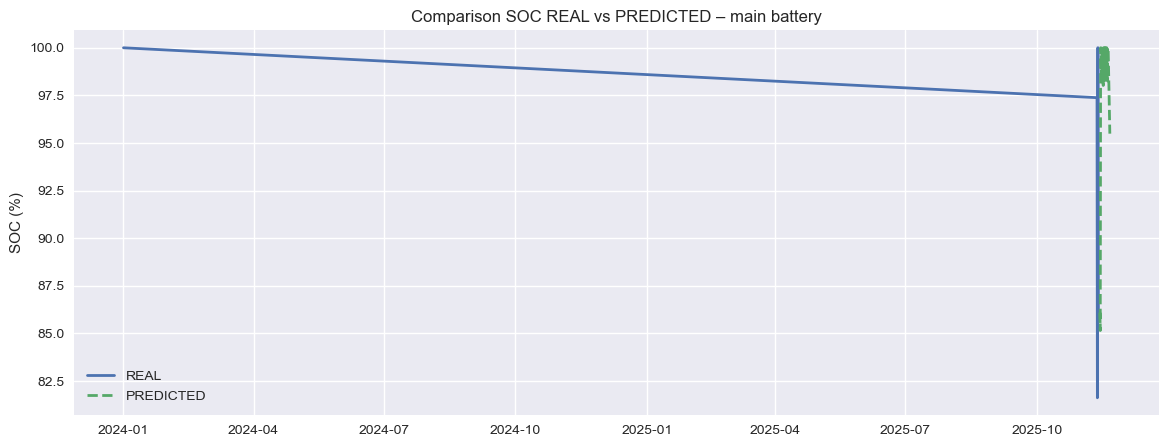

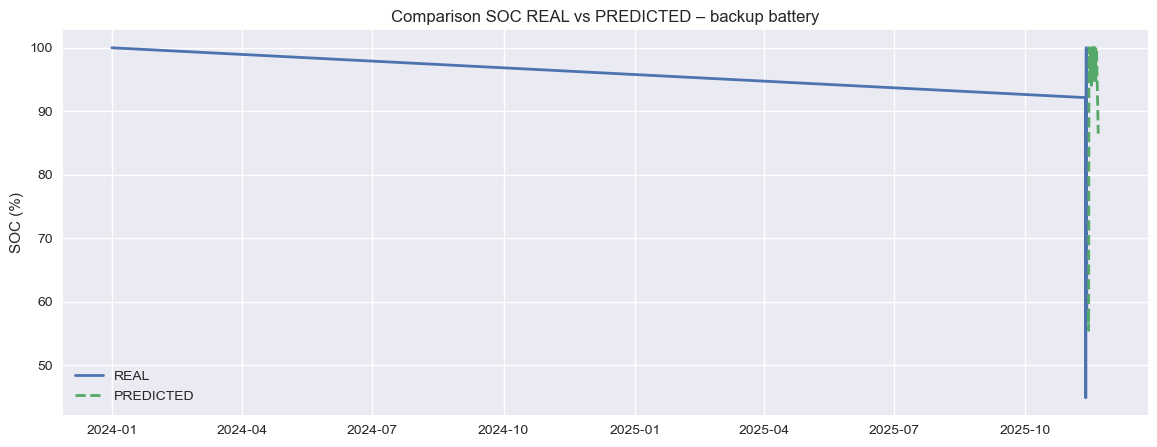

In [9]:
def compare_soc(real, pred, btype="main"):
    plt.figure(figsize=(14,5))
    r = real[real.battery_type==btype]
    p = pred[pred.battery_type==btype]

    plt.plot(r.timestamp, r.soc_end_pct, label="REAL", linewidth=2)
    plt.plot(p.timestamp, p.soc_end_pct, label="PREDICTED", linewidth=2, linestyle='--')

    plt.ylabel("SOC (%)")
    plt.title(f"Comparison SOC REAL vs PREDICTED – {btype} battery")
    plt.legend()
    plt.grid(True)
    plt.show()

compare_soc(df_real, df_pred, "main")
compare_soc(df_real, df_pred, "backup")


ModuleNotFoundError: No module named 'src'